# Data Science Course Final Project: *Predicting Health Care Seeking Patterns*

## 1. Problem Statement
For my final project, I would like to build a model that can **predict where patients will seek care for different health issues.** In every health system, there are a variety of health providers that people can visit to address health issues that arise. Global surveys of health behavior have found that many factors influence patient health seeking behavior, including distance from their home, cost of the provider, attitudes towards the government, and education levels. Patient care seeking patterns are one indicator of patient prefererences for health care in their country and could inform public health officials on which types of health providers they ought to use to meet patients where they prefer to receive healthcare.

However, in many countries data does not exist on where patients seek care for health services, leaving public health officials to choose the location of service delivery based primarily on where it is easiest to deliver the services, rather than where it is preferrable to deliver the services from a patient's perspective. 

*How Model Can Inform Decision Making*

Using data from Demographic and Health Surveys (DHS), I want to build a model that can predict patient care seeking patterns, leveraging commonly available demographic data as the primary features informing those predictions. Using this model, public health officials could make better decisions about where it is best to delivery public health interventions based on patient care seeking preferences. This model would be especially useful for settings that don't have data on patient care seeking, but do collect data on commonly available deomgrpahic information. 

## 2. Approach Overview

### 2.1 Data Source
The Demographic and Health Surveys (DHS) are surveys implemented nationally in many countries around the world. They provide information on key demographic and health behavior indicators. Countries often conduct a DHS every five years to allow for analysis over time and tracking of their progression against key population health indicators (e.g. immunization coverage or access to contraception).

For this project, I will leverage the most recent survey from Namibia. Different survey instruments are used for different groups of the population. The broadest and most comprehensive survey is the individual recode survey, which is given to women ages 15-49. The surveys are powered to the stratum level (every urban/rural x region combination), allowing for potential subnational variation to inform predictions. I will only use the individual recode survey for my model. 

### 2.2 Target Variables
Initially, I wanted to use several target variables to see if there are care seeking patterns that are predictable given a set of baseline demogrpahic information. The target variables that I wanted to explore were:

    - Place first sought for treatment of diarrhea (H44A)
    - Place first sought for treatment of fever (H46A)
    - Place of delivery of child (M15)
    - Place of first postnatal checkup (M73)
    
However, I found that in this dataset, there were only a small number of observations for diarrhea, fever, and postnatal check-up care seeking patterns. The dataset had a larger number of observations for women who reported where they delivered the child. So for the final project, I focused on building a model that could **predict where mothers would give birth to their children (variable M15)** using a set of demographic variables as my feature set. 

The responses to this question include approximatly 10 different categories for where patients could devlier their baby. This includes facilites in both the public and private sector, as well as home births. To simplify the model, I will look at trying to predict the sector of the facility where the baby was delivered - amongst the choies of: public, private, home, and other.

### 2.3 Feature Variables
The Demographic and Health Survey (DHS) includes more than 3000 variables related to health and demographics of the respondents. However, to make this model valuable for public health practitioners, I wanted to try to find a minimal set of demogrpahic variables that are commonly available, but still have predictive power for care seeking patterns. The subset of variables that I am using in my model include:
- Region of respondent
- Urban|Rural status of respondent
- Religion
- Wealth index (standarized index of intra-country wealth levels)
- Years of education
- Number of kids under 5 years old

### 2.4 Model Approach
The problem described above is a classification problem - I am attempting to classify people into locations of seeking care. I tested three different classification models for this problem. The first was a KNearestNeighbors model, the second a decision tree model, and the third a random forest model. I will use prediction accuracy as the primary metric to evaluate each model. I may also look at Gini index as an evaluation metric. 

## 3. Data Preparation

In [1]:
#Notebook preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import DescrStatsW
from pathlib import Path

#Import visualization libraries 
import matplotlib.pyplot as plt
import seaborn as sns

#Import libraries required for modeling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
# There are thousands of variables included in a DHS survey. I don't need all of them for my analysis so I am going to only load the variables I'm interested in. 
# Each data file comes with an accompanying data dictionary, so I've already identified the variable names that I'm interested in. 
# I've loaded a few extra variables in case I wanted to use them for further analysis
dhs_variables = ["v005","v012","v024","v025", "v130", "v119", "v120", "v121", 
                 "v153", "v113", "v115", "v123", "v124", "v125", "v190","v133", "v137", "h44a_1", "h46a_1", "m15_1", "m73_1"]

# Data in DHS surveys come in several forms. I'm using the .dta file type which is typically created for us in Stata
# load the data from the namibia DHS dataset
data = Path('Datasets','NMIR61FL.DTA')
nmb_dhs = pd.read_stata(data, columns = dhs_variables)

#create a dataset that focuses on only the values of women ages 15-49. the survey notes suggest that there were 842 women who were added (over the ages of 50) in half of the households survyed. 
nmb_dhs = nmb_dhs.loc[nmb_dhs.loc[:,"v012"]<50,:]

#rename all of our columns to give them understandable names
nmb_dhs.rename(columns={
        "v005":'svy_weight',"v012":'age',"v024":'region',"v025":'urb_rur', "v130":'religion', "v119":'has_electric', "v120":'has_radio', "v121":'has_tv', 
        "v153":'has_land_phone', "v113":'source_water', "v115":'time_to_water', "v123":'has_bicycle', "v124":'has_moto_scooter', "v125":'has_car_truck', 
        "v190":'wealth_index',"v133":'edu_years', "v137":'num_kids_u5', "h44a_1":'diarrhea_cs', "h46a_1":'fever_ds', "m15_1":'place_delivery', "m73_1":'postnatal_check'},inplace=True)


### 3.1 Testing for and Handling Missing Values

In [3]:
#I've gone ahead and dropped all rows where there isn't a response to the place of delivery variable. 
#I made a new data frame that just focuses on those respondents who had a kid and reported the place of delivery for that child.
nmb_dhs_birth_cs = nmb_dhs.loc[nmb_dhs.loc[:,'place_delivery'].notnull(),:]

# I also dropped the other care seeking variables that I won't be using for this model. This just leaves place of delivery as the primary target variable 
nmb_dhs_birth_cs = nmb_dhs_birth_cs.drop(['diarrhea_cs', 'fever_ds', 'postnatal_check'], axis = 1)

# Finally, I dropped the remaining rows that had missing data for any of my feature varibles. This only dropped 53 rows, leaving me with 3925 observations for my main data
nmb_dhs_birth_cs.dropna(inplace = True)
nmb_dhs_birth_cs.isnull().sum()

svy_weight          0
age                 0
region              0
urb_rur             0
religion            0
has_electric        0
has_radio           0
has_tv              0
has_land_phone      0
source_water        0
time_to_water       0
has_bicycle         0
has_moto_scooter    0
has_car_truck       0
wealth_index        0
edu_years           0
num_kids_u5         0
place_delivery      0
dtype: int64

In [4]:
nmb_dhs_birth_cs.shape

(3925, 18)

### 3.2 Cleaning Feature Variables

In [5]:
#The education years variable was read in as a categorical variable
#Change the education years to a floating variable (numeric), rather than a categorical variable
nmb_dhs_birth_cs.loc[:,'edu_years'] = pd.to_numeric(nmb_dhs_birth_cs.loc[:,'edu_years'])

In [6]:
#I mapped each of the regions to a numerical category rather than a string
nmb_dhs_birth_cs.loc[:,'region_num'] = nmb_dhs_birth_cs.loc[:,'region'].map(
    {'kavango':1, 'khomas':2,'ohangwena':3, 'caprivi':4, 'otjozondjupa':5, 'kunene':6, 'erongo':7,
     'karas':8, 'omusati':9, 'oshikoto':10,'hardap':11,'omaheke':12,'oshana':13})

In [7]:
#The wealth index variable includes 5 categories. Rather than a single categorical variable, I turned it into four dummy variables
nmb_dhs_birth_cs.loc[:,'wealth_orig'] = nmb_dhs_birth_cs.loc[:,'wealth_index']
nmb_dhs_birth_cs = pd.get_dummies(nmb_dhs_birth_cs, columns=['wealth_index'],drop_first=True)

In [8]:
nmb_dhs_birth_cs.loc[:,'wealth_orig_num'] = nmb_dhs_birth_cs.loc[:,'wealth_orig'].map({'poorest':1,'poorer':2,'middle':3,'richer':4,'richest':5})

In [9]:
#The religion variable includes multiple categories. Rather than a single categorical variable, I turned it into separate dummy variables
nmb_dhs_birth_cs.loc[:,'religion_orig'] = nmb_dhs_birth_cs.loc[:,'religion']
nmb_dhs_birth_cs = pd.get_dummies(nmb_dhs_birth_cs, columns=["religion"], drop_first=True)

In [10]:
#I categorized the urban|rural variable into a dummy with urban = 1 and rural = 0
nmb_dhs_birth_cs.loc[:,'urb_rur_dum'] = nmb_dhs_birth_cs.loc[:,"urb_rur"].map({'urban':1,'rural':0})

### 3.3 Cleaning Target Variable

In [11]:
#First step is to map each delivery facility to a specific sector. 
#The below code maps all the facilities to a specific sector.
nmb_dhs_birth_cs.loc[:,'delivery_sector'] = nmb_dhs_birth_cs.loc[:,'place_delivery'].map(
    {'government hospital':'public', 'government health care clinic':'public','government health center':'public', 
     'private hospital':'private', 'private clinic':'private', "respondent's home":'home', 'other home':'home',
    'other':'other', 'outreach point': 'other', 'other public':'public'})

In [12]:
#I then converted each of the sectors into a numerical variable so we could use it for prediction
nmb_dhs_birth_cs.loc[:,'delivery_sector_num'] = nmb_dhs_birth_cs.loc[:,'delivery_sector'].map({'public':1, 'private':2,'home':3,'other':4})

In [13]:
#I'm also going to create a column that has the delivery level (with level 2 being hospitals, level 1 being clinics and level 0 being community or home)
nmb_dhs_birth_cs.loc[:,'delivery_level'] = nmb_dhs_birth_cs.loc[:,'place_delivery'].map(
    {'government hospital':2, 'government health care clinic':1,'government health center':1, 
     'private hospital':2, 'private clinic':1, "respondent's home":0, 'other home':0,
    'other':1, 'outreach point': 0, 'other public':1})

### 3.4 Summary of Final Clean Dataset

In [14]:
#Columns now included in the dataset
nmb_dhs_birth_cs.columns

Index(['svy_weight', 'age', 'region', 'urb_rur', 'has_electric', 'has_radio',
       'has_tv', 'has_land_phone', 'source_water', 'time_to_water',
       'has_bicycle', 'has_moto_scooter', 'has_car_truck', 'edu_years',
       'num_kids_u5', 'place_delivery', 'region_num', 'wealth_orig',
       'wealth_index_poorer', 'wealth_index_middle', 'wealth_index_richer',
       'wealth_index_richest', 'wealth_orig_num', 'religion_orig',
       'religion_protestant/anglican', 'religion_elcin',
       'religion_seventh-day adventist', 'religion_no religion',
       'religion_other', 'urb_rur_dum', 'delivery_sector',
       'delivery_sector_num', 'delivery_level'],
      dtype='object')

In [93]:
#Top 15 rows of my new dataset
nmb_dhs_birth_cs.head(15)

,svy_weight,age,region,urb_rur,has_electric,has_radio,has_tv,has_land_phone,source_water,time_to_water,...,religion_orig,religion_protestant/anglican,religion_elcin,religion_seventh-day adventist,religion_no religion,religion_other,urb_rur_dum,delivery_sector,delivery_sector_num,delivery_level
1,564917,25,caprivi,rural,no,no,no,no,public tap/standpipe,5,...,other,0,0,0,0,1,0,public,1,2
2,564917,31,caprivi,rural,no,no,no,no,public tap/standpipe,on premises,...,protestant/anglican,1,0,0,0,0,0,home,3,0
4,564917,35,caprivi,rural,no,yes,no,no,public tap/standpipe,20,...,seventh-day adventist,0,0,1,0,0,0,public,1,2
6,564917,41,caprivi,rural,no,no,no,no,public tap/standpipe,20,...,seventh-day adventist,0,0,1,0,0,0,home,3,0
7,564917,38,caprivi,rural,no,no,no,no,public tap/standpipe,2,...,protestant/anglican,1,0,0,0,0,0,public,1,2
8,564917,19,caprivi,rural,no,no,no,no,public tap/standpipe,2,...,protestant/anglican,1,0,0,0,0,0,public,1,2
9,564917,35,caprivi,rural,no,no,no,no,tube well or borehole,60,...,seventh-day adventist,0,0,1,0,0,0,public,1,1
10,564917,30,caprivi,rural,no,yes,yes,no,river/dam/lake/ponds/stream/canal/irrigation c...,60,...,elcin,0,1,0,0,0,0,public,1,2
11,564917,19,caprivi,rural,no,yes,no,no,tube well or borehole,60,...,seventh-day adventist,0,0,1,0,0,0,public,1,2
12,564917,31,caprivi,rural,no,no,no,no,public tap/standpipe,on premises,...,seventh-day adventist,0,0,1,0,0,0,home,3,0


In [16]:
#Summary statsitics about my numerical variables
nmb_dhs_birth_cs.describe()

,svy_weight,age,edu_years,num_kids_u5,region_num,wealth_index_poorer,wealth_index_middle,wealth_index_richer,wealth_index_richest,wealth_orig_num,religion_protestant/anglican,religion_elcin,religion_seventh-day adventist,religion_no religion,religion_other,urb_rur_dum,delivery_sector_num,delivery_level
count,3.925000e+03,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000,3925.000000
mean,9.659476e+05,28.967898,8.376306,1.595159,6.494268,0.215541,0.224459,0.222420,0.141146,2.896306,0.231338,0.389045,0.064459,0.019618,0.078471,0.473631,1.305732,1.688153
std,5.603291e+05,7.226423,3.722784,1.192880,3.712980,0.411250,0.417278,0.415925,0.348217,1.333409,0.421741,0.487596,0.245599,0.138701,0.268946,0.499368,0.697513,0.679970
min,1.192350e+05,15.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.649170e+05,23.000000,7.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
50%,9.215250e+05,28.000000,9.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,1.191194e+06,34.000000,10.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
max,4.368840e+06,49.000000,22.000000,8.000000,13.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.000000


In [17]:
#Summary statistics about my non-numerical variables
nmb_dhs_birth_cs.describe(include = ['category','object'])

,region,urb_rur,has_electric,has_radio,has_tv,has_land_phone,source_water,time_to_water,has_bicycle,has_moto_scooter,has_car_truck,place_delivery,wealth_orig,religion_orig,delivery_sector
count,3925,3925,3925,3925,3925,3925,3925,3925,3925,3925,3925,3925,3925,3925,3925
unique,13,2,3,3,3,3,15,50,3,3,3,10,5,6,4
top,kavango,rural,no,yes,no,no,piped into dwelling,on premises,no,no,no,government hospital,middle,elcin,public
freq,391,2066,2095,2554,2182,3648,1143,1830,3344,3785,3029,3019,881,1527,3245


## 4. Exploratory Data Analysis

In [18]:
#Create cross_tabs of each my most important categorical features against my target variable to see if there is 
#strong alignment with any one of my feature values and certain values in the target variable 
delivery_sector_religion = pd.crosstab(nmb_dhs_birth_cs.loc[:,'religion_orig'],nmb_dhs_birth_cs.loc[:,'delivery_sector'],normalize = 'index', margins = True).round(2)
delivery_sector_wealth = pd.crosstab(nmb_dhs_birth_cs.loc[:,'wealth_orig'],nmb_dhs_birth_cs.loc[:,'delivery_sector'],normalize = 'index', margins = True).round(2)
delivery_sector_urb_rur = pd.crosstab(nmb_dhs_birth_cs.loc[:,'urb_rur'],nmb_dhs_birth_cs.loc[:,'delivery_sector'],normalize = 'index', margins = True).round(2)

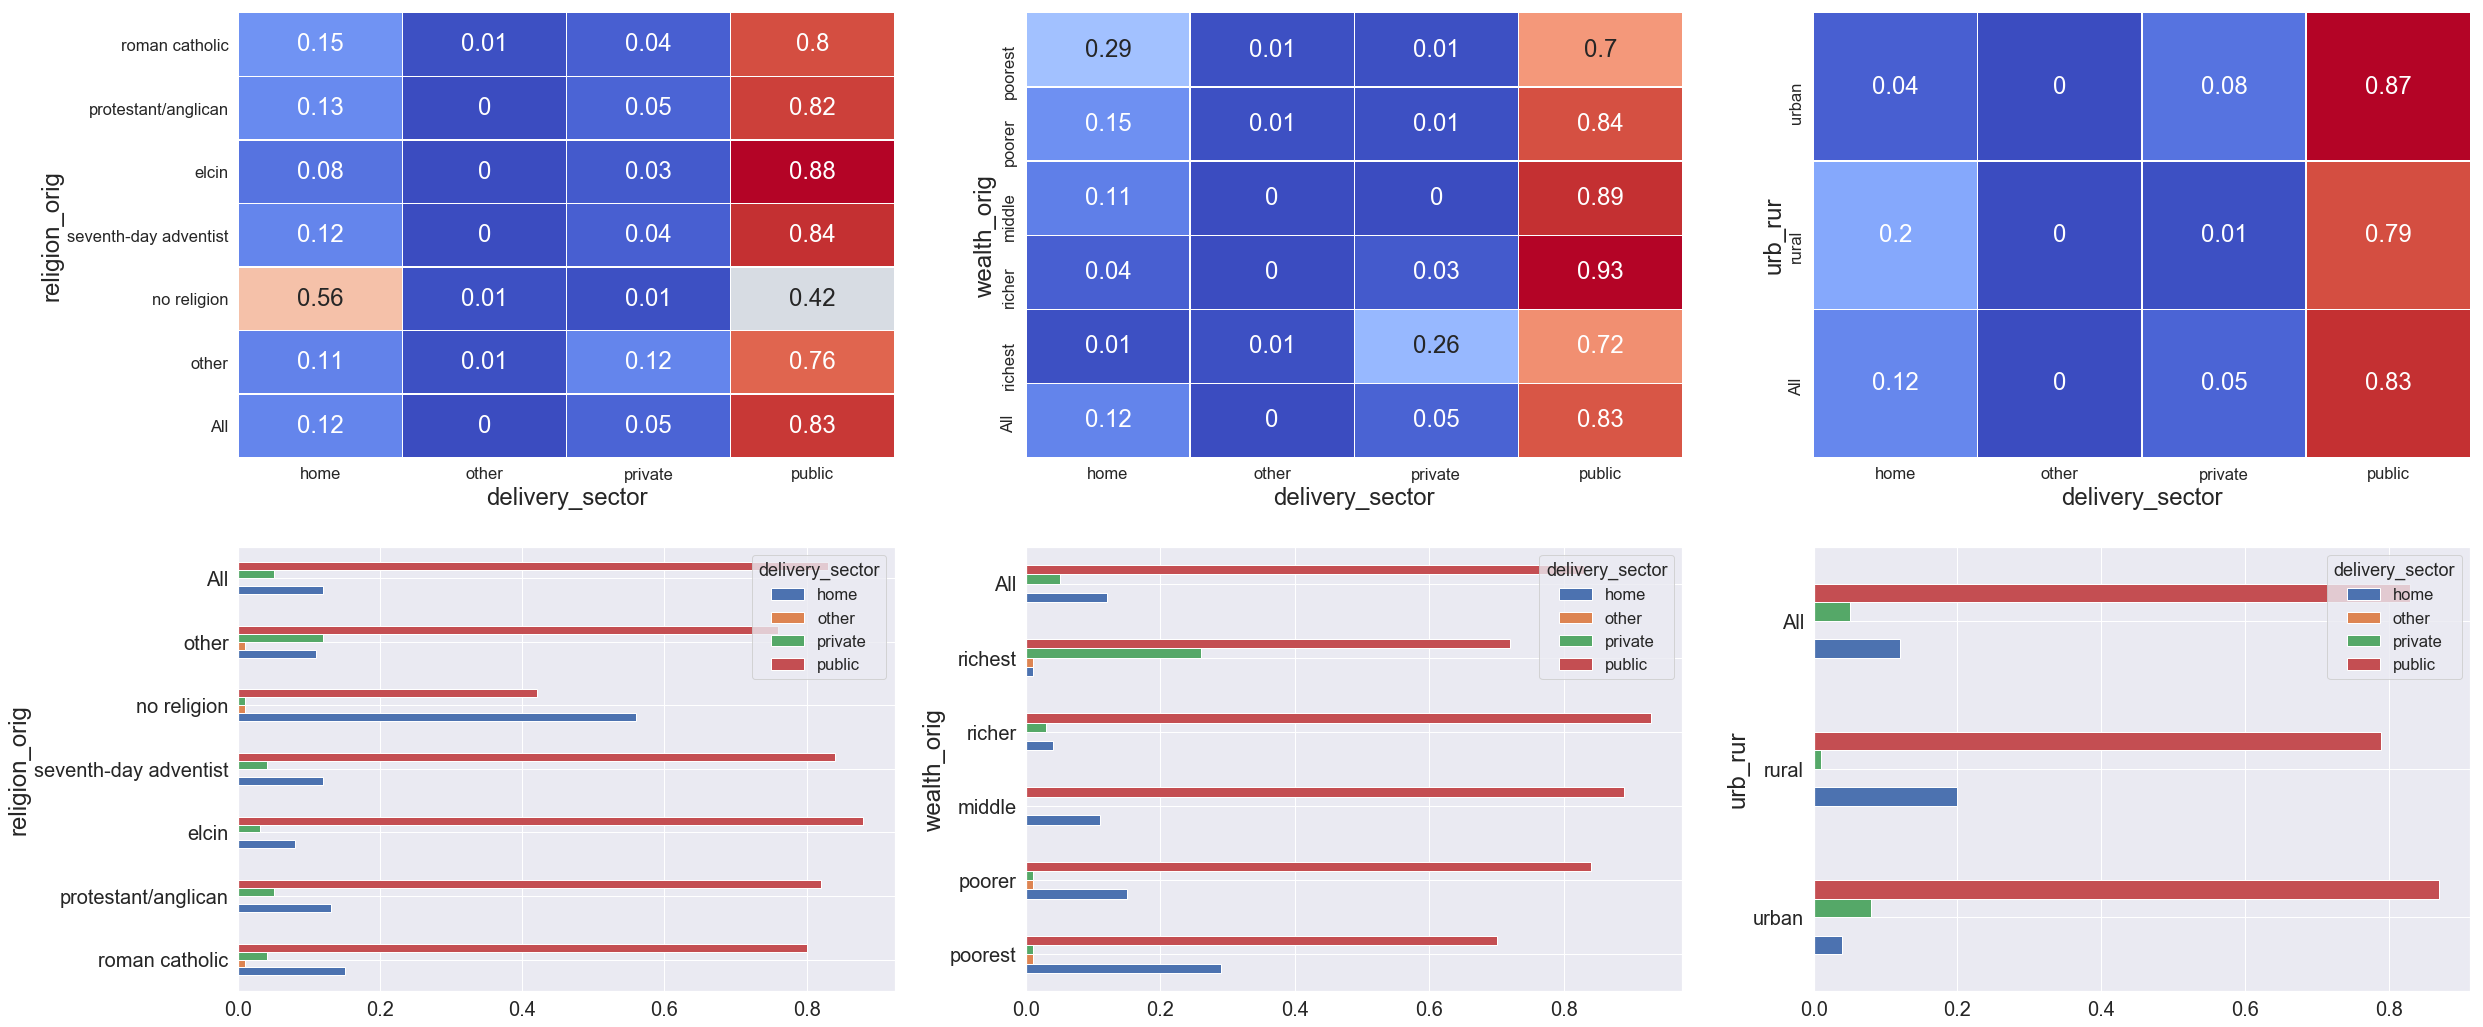

In [71]:
fig, axes = plt.subplots(2,3,figsize=(40,18))

religion_delivery = sns.heatmap(delivery_sector_religion, annot = True, linewidths = .25, cmap="coolwarm", cbar=False, ax = axes[0][0],annot_kws={"size":24})
wealth_delivery = sns.heatmap(delivery_sector_wealth, annot = True, linewidths = .25, cmap="coolwarm", cbar=False, ax = axes[0][1],annot_kws={"size":24})
religion_delivery = sns.heatmap(delivery_sector_urb_rur, annot = True, linewidths = .25, cmap="coolwarm", cbar=False, ax = axes[0][2],annot_kws={"size":24})

delivery_sector_religion.plot(kind='barh',ax=axes[1][0], fontsize=20)
delivery_sector_wealth.plot(kind='barh',ax=axes[1][1], fontsize=20)
delivery_sector_urb_rur.plot(kind='barh', ax=axes[1][2], fontsize=20);

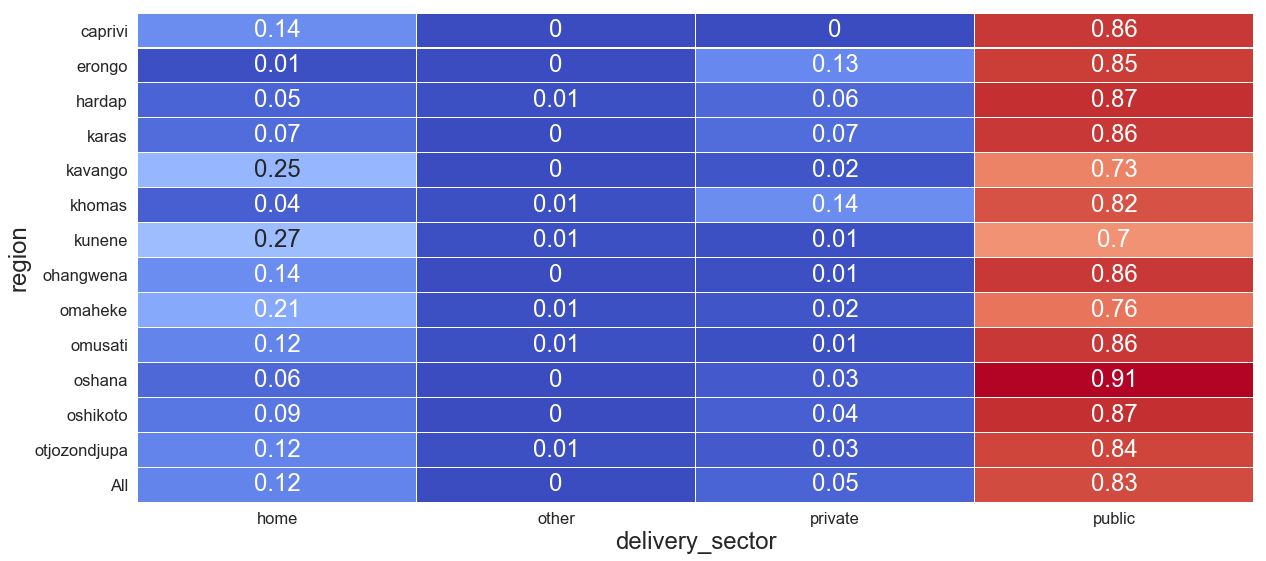

In [103]:
#Check to see if there is any regional distribution
fig, ax = plt.subplots(figsize=(20,9))
delivery_sector_religion = pd.crosstab(nmb_dhs_birth_cs.loc[:,'region'],nmb_dhs_birth_cs.loc[:,'delivery_sector'],normalize = 'index', margins = True).round(2)
region_delivery = sns.heatmap(delivery_sector_religion, annot = True, linewidths = .25, cmap="coolwarm", cbar=False, ax = ax,annot_kws={"size":24})


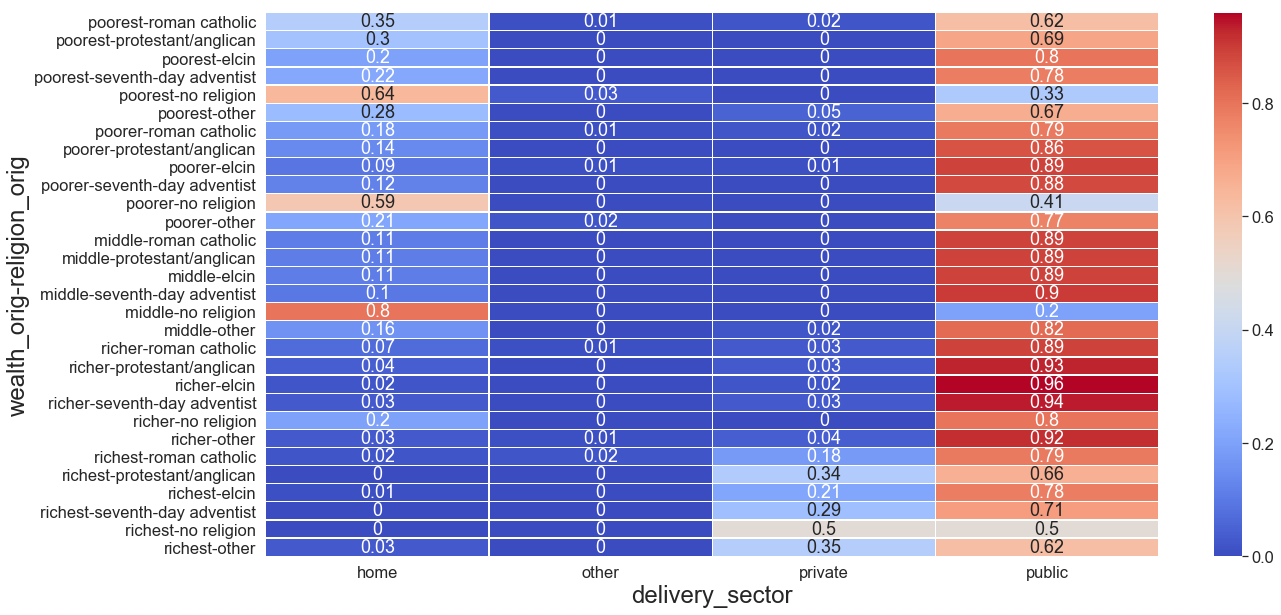

In [104]:
#Compare a crosstab of religion and wealth to place of delivery
delivery_sector_religion_wealth = pd.crosstab([nmb_dhs_birth_cs.loc[:,'wealth_orig'],nmb_dhs_birth_cs.loc[:,'religion_orig']],nmb_dhs_birth_cs.loc[:,'delivery_sector'],normalize = 'index').round(2)
fig, ax = plt.subplots(figsize=(20,10))
religion_wealth_delivery_plot = sns.heatmap(delivery_sector_religion_wealth, annot = True, linewidths = .25, cmap="coolwarm", ax=ax)


## 5. Model Building 

### 5.1 Decision Tree Model

In [116]:
#1. Define X and y variables
features_tree = ['age','region_num','wealth_index_poorer','wealth_index_middle','wealth_index_richer','wealth_index_richest','edu_years','urb_rur_dum',
                'religion_protestant/anglican','religion_elcin', 'religion_seventh-day adventist','religion_no religion', 'religion_other','num_kids_u5']

X_tree = nmb_dhs_birth_cs.loc[:, features_tree]
y_tree = nmb_dhs_birth_cs.loc[:, 'delivery_sector_num']

In [117]:
#2. Create train and test splits
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y_tree, shuffle=True)

In [118]:
#3. Create an oversampled training set to adjust for imbalanced target variable
X_samp_tree_train, y_samp_tree_train = SMOTE().fit_resample(X_tree_train, y_tree_train)

## Show the results of the overbalanced target variable compared to the results of the normal target variable 
print(y_tree_train.value_counts())
print(pd.DataFrame(y_samp_tree_train).loc[:,0].value_counts())

1    2442
3     364
2     123
4      14
Name: delivery_sector_num, dtype: int64
4    2442
3    2442
2    2442
1    2442
Name: 0, dtype: int64


In [119]:
#4. Instatiate decision tree model
nmb_tree = DecisionTreeClassifier()

In [120]:
#5. Fit the model to my oversampled training set
nmb_tree.fit(X_samp_tree_train, y_samp_tree_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [121]:
#6. Predict the values of my training and test set
y_samp_tree_train_predict = nmb_tree.predict(X_samp_tree_train)
y_tree_test_predict = nmb_tree.predict(X_tree_test)

In [122]:
#7. Report the scores from my predictions of the training and test set

tree_null_accuracy = y_tree.value_counts(normalize = True).max().round(3)
tree_training_accuracy = metrics.accuracy_score(y_samp_tree_train,y_samp_tree_train_predict).round(3)
tree_test_accuracy = metrics.accuracy_score(y_tree_test,y_tree_test_predict).round(3)

print("Predcicting just the most common value would result in: ", tree_null_accuracy)
print("DecisionTree accuracy on training set: ", tree_training_accuracy)
print("DecisionTree accuracy on test set:", tree_test_accuracy)

Predcicting just the most common value would result in:  0.827
DecisionTree accuracy on training set:  0.999
DecisionTree accuracy on test set: 0.728


In [123]:
#8. Identify which features are my most important features
pd.DataFrame({'feature': features_tree, 'importance': nmb_tree.feature_importances_})

,feature,importance
0,age,0.146259
1,region_num,0.089612
2,wealth_index_poorer,0.049084
3,wealth_index_middle,0.008977
4,wealth_index_richer,0.013975
5,wealth_index_richest,0.107111
6,edu_years,0.312013
7,urb_rur_dum,0.134235
8,religion_protestant/anglican,0.015580
9,religion_elcin,0.037548


### 5.2 RandomForest Model

In [124]:
#1. Define X and y variables
excluded_features = []

features_rf = ['age','region_num','wealth_index_poorer','wealth_index_middle','wealth_index_richer','wealth_index_richest','edu_years',
                'religion_protestant/anglican','religion_elcin', 'religion_seventh-day adventist','religion_no religion', 'religion_other','urb_rur_dum','num_kids_u5']


X_rf = nmb_dhs_birth_cs.loc[:, features_rf]
y_rf = nmb_dhs_birth_cs.loc[:, 'delivery_sector_num']

In [125]:
#2. Create train and test splits
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, shuffle=True)

In [126]:
#3. Create an oversampled training set to adjust for imbalanced target variable
X_samp_rf_train, y_samp_rf_train = SMOTE().fit_resample(X_rf_train, y_rf_train)

## Show the results of the overbalanced target variable compared to the results of the normal target variable 
print(y_rf_train.value_counts())
print(pd.DataFrame(y_samp_rf_train).loc[:,0].value_counts())

1    2437
3     360
2     133
4      13
Name: delivery_sector_num, dtype: int64
4    2437
3    2437
2    2437
1    2437
Name: 0, dtype: int64


In [127]:
#4. Instatiate decision tree model
nmb_rf = RandomForestClassifier()

In [128]:
#5. Fit the model to my oversampled training set
nmb_rf.fit(X_samp_rf_train, y_samp_rf_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [129]:
#6. Predict the values of my training and test set
y_samp_rf_train_predict = nmb_rf.predict(X_samp_rf_train)
y_rf_test_predict = nmb_rf.predict(X_rf_test)

In [130]:
#7. Report the scores from my predictions of the training and test set

rf_null_accuracy = y_rf.value_counts(normalize = True).max().round(3)
rf_training_accuracy = metrics.accuracy_score(y_samp_rf_train,y_samp_rf_train_predict).round(3)
rf_test_accuracy = metrics.accuracy_score(y_rf_test,y_rf_test_predict).round(3)

print("Predcicting just the most common value would result in: ", rf_null_accuracy)
print("RandomForest model accuracy on training set: ", rf_training_accuracy)
print("RandomForest model accuracy on test set:", rf_test_accuracy)

Predcicting just the most common value would result in:  0.827
RandomForest model accuracy on training set:  0.995
RandomForest model accuracy on test set: 0.826


In [131]:
#8. Identify which features are my most important features
pd.DataFrame({'feature': features_rf, 'importance': nmb_rf.feature_importances_})

,feature,importance
0,age,0.115715
1,region_num,0.095585
2,wealth_index_poorer,0.074785
3,wealth_index_middle,0.037182
4,wealth_index_richer,0.045007
5,wealth_index_richest,0.173987
6,edu_years,0.140266
7,religion_protestant/anglican,0.046890
8,religion_elcin,0.052134
9,religion_seventh-day adventist,0.014435


## 6. Model Evaluation

It seems like I have some issues with the model. I'm not entirely sure what is going on, but I can't make a model better than the null model. Clearly my model has high variance and low bias, Despite the training set having high accuracy (higher than the null model), the test results are slightly lower than the null model.

In [132]:
#Create a results summary table
model_type = ['DecisionTree', 'RandomForest']
null_model = [tree_null_accuracy, rf_null_accuracy]
training_results = [tree_training_accuracy, rf_training_accuracy]
test_results = [tree_test_accuracy, rf_test_accuracy]

results_df = pd.DataFrame({'model_type':model_type, 'null_results':null_model, 'training_results':training_results, 'test_results':test_results})
results_df


,model_type,null_results,training_results,test_results
0,DecisionTree,0.827,0.999,0.728
1,RandomForest,0.827,0.995,0.826
